In [2]:
import os #Thư viện tương tác với HĐH
import numpy as np #Thư viện xử lý dữ liệu số
import tensorflow as tf #Thư viện cung cấp CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Thư viện tăng cường dữ liệu ảnh
from tensorflow.keras.models import Sequential #Thư viện xd và huấn luyện mô hình theo tuần tự
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout #Thư viện xử lý ảnh
from tensorflow.keras.optimizers import Adam #Thư viện có thuật toán tối ưu

In [3]:
from google.colab import drive #Kết nối google drive vs google colab
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train_dir = '/content/gdrive/MyDrive/AnhNhanDien' #Trỏ đến kho ảnh huấn luyện

In [5]:
#Tạo một đối tượng giúp nhận diện khuôn mặt
train_datagen = ImageDataGenerator(
    rescale=1./255, #Chuẩn hóa các pixel giá trị của hình ảnh về khoảng [0, 1]
    rotation_range=40, #Xoay ngẫu nhiên ảnh trong phạm vi ±40 độ
    width_shift_range=0.2, #Chuyển hình ảnh ngẫu nhiên theo chiều ngang và chiều dọc trong khoảng ảnh kích thước khoảng ±20%.
    height_shift_range=0.2,
    shear_range=0.2, #Biến dạng
    zoom_range=0.2, #Phóng
    horizontal_flip=True, #Bật hình ảnh
    fill_mode='nearest', #Xác định cách điền các khoảng trống pixel khi thực hiện các biến được phép như xoay, chuyển, phóng to hoặc thu nhỏ
    validation_split=0.2 #Chia dữ liệu thành tập huấn luyện và kiểm tra
)

In [6]:
#Dùng để huấn luyện
train_generator = train_datagen.flow_from_directory(
    train_dir,#Đường dẫn đến thư mục chứa dữ liệu huấn luyện
    target_size=(224, 224), #Các hình ảnh từ thư mục sẽ được thay đổi kích thước về 224x224pixel
    batch_size=32, #Dữ liệu được trả về theo từng lô gồm 32 ảnh
    class_mode='categorical', #Chỉ định nhãn của hình ảnh thuộc dạng phân loại đa lớp
    subset='training'# Sử dụng tập dữ liệu huấn luyện
)

Found 48 images belonging to 4 classes.


In [7]:
print(train_generator.class_indices) #in ra một dictionary ánh xạ các nhãn (labels) lớp sang các chỉ số (indices) tương ứng.

{'Duc': 0, 'Long': 1, 'Manh': 2, 'Truong': 3}


In [8]:
#Dùng để kiểm tra
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 12 images belonging to 4 classes.


In [9]:
#Mô hình cơ sở để nhận diện khuôn mặt
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet') #Đầu vào của mô hình là ảnh có kích thước 224x224 với 3 kênh màu (RGB),
#include_top=False: Loại bỏ các lớp fully connected (FC) và lớp softmax ở cuối mô hình VGG16. Điều này cho phép sử dụng mô hình như một bộ trích xuất đặc trưng
#weights='imagenet': Sử dụng trọng số được huấn luyện trên ImageNet
base_model.trainable = False #Đóng băng toàn bộ các lớp trong base_model, nghĩa là trọng số của chúng sẽ không thay đổi trong quá trình huấn luyện. Điều này giúp giữ lại các đặc trưng đã học được từ ImageNet.

model = Sequential([
    base_model, #Phần trích xuất đặc trưng
    Flatten(),  #Chuyển đổi đầu ra của base_model từ dạng tensor (4D) sang dạng vector (1D) để đưa vào lớp fully connected.
    Dense(512, activation='relu'), #Thêm một lớp fully connected với 512 nơ-ron và hàm kích hoạt ReLU. Đây là lớp học các đặc trưng phức tạp hơn.
    Dropout(0.5), #Thả rơi ngẫu nhiên 50% các nơ-ron trong lớp trước để giảm hiện tượng overfitting.
    Dense(4, activation='softmax') #Lớp đầu ra với 4 nơ-ron (vì bài toán có 4 lớp) và hàm kích hoạt softmax để trả về xác suất của từng lớp.
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #Biên dịch mô hình học

In [11]:
#Huấn luyện mô hình
history = model.fit(
    train_generator, #Mỗi lần gọi train_generator sẽ trả về một batch dữ liệu
    steps_per_epoch=50, #Số bước (batch) mà mô hình sẽ chạy trong mỗi epoch.
    epochs=30, #Số lần huấn luyện toàn bộ tập dữ liệu (epoch), Trong mỗi epoch, mô hình sẽ duyệt qua toàn bộ tập dữ liệu huấn luyện.
    validation_data=validation_generator, #Số bước (batch) mà mô hình sẽ chạy trên tập kiểm tra sau mỗi epoch.
    validation_steps=50 #Số bước
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/50 ━━━━━━━━━━━━━━━━━━━━ 15:45 20s/step - accuracy: 0.2708 - loss: 1.9781

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 945ms/step - accuracy: 0.2308 - loss: 1.8435 - val_accuracy: 0.5833 - val_loss: 1.1078
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 588ms/step - accuracy: 0.5204 - loss: 1.1566 - val_accuracy: 0.7500 - val_loss: 0.8013
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 424ms/step - accuracy: 0.5638 - loss: 1.1647 - val_accuracy: 0.6667 - val_loss: 0.8452
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 352ms/step - accuracy: 0.6448 - loss: 0.9815 - val_accuracy: 0.9167 - val_loss: 0.5201
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 352ms/step - accuracy: 0.8546 - loss: 0.6991 - val_accuracy: 1.0000 - val_loss: 0.3139
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 550ms/step - accuracy: 0.8317 - loss: 0.4639 - val_accuracy: 1.0000 - val_loss: 0.2105
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 538ms/step - accuracy: 0.9375 - loss: 0.3189 - val_accuracy: 1.0000 - val_loss: 0.1429
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 639ms/step - accuracy: 0.9362 - loss: 0.3044 - val_accuracy: 0.833

In [ ]:
#Tăng cường huấn luyện
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 300ms/step - accuracy: 1.0000 - loss: 0.0246 - val_accuracy: 1.0000 - val_loss: 0.0205
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 296ms/step - accuracy: 0.9588 - loss: 0.0760 - val_accuracy: 1.0000 - val_loss: 0.0139
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - accuracy: 1.0000 - loss: 0.0374 - val_accuracy: 1.0000 - val_loss: 0.0189
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 318ms/step - accuracy: 0.9787 - loss: 0.0798 - val_accuracy: 1.0000 - val_loss: 0.0107
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 214ms/step - accuracy: 1.0000 - loss: 0.0516 - val_accuracy: 1.0000 - val_loss: 0.0112
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 342ms/step - accuracy: 1.0000 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0062
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 78s 300ms/step - accuracy: 1.0000 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 191ms/step - accuracy: 1.0000 - loss: 0

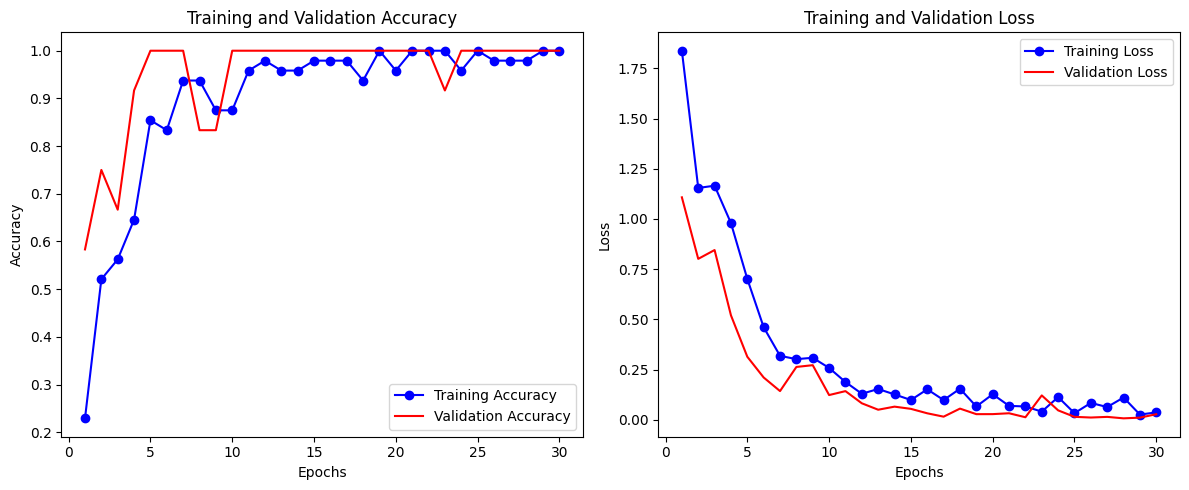

In [12]:
#Vẽ sơ đồ theo dõi
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
model.save('face_recognition_model.h5') #Lưu mô hình đã huấn luyện

In [14]:
import cv2 #Thư viện xử lý ảnh và video
from tensorflow.keras.models import load_model #tải lại mô hình học sâu đã được huấn luyện trước đó

In [15]:
#tải mô hình phát hiện khuôn mặt sử dụng phương pháp Haar Cascade giúp nhận diện khuôn mặt trong ảnh
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [16]:
#sử dụng mô hình Haar Cascade để phát hiện khuôn mặt trong ảnh.
face_cascade

< cv2.CascadeClassifier 0x7e88cf7ab230>

In [17]:
#điều chỉnh độ sáng của một bức ảnh đầu vào
def adjust_brightness(image, brightness_factor=1.2):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:, :, 2] = hsv[:, :, 2] * brightness_factor
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255
    hsv = np.array(hsv, dtype=np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

In [18]:
#dùng để nhận diện khuôn mặt trong một bức ảnh và dự đoán tên người trong các khuôn mặt đó,
#dựa trên một mô hình học sâu đã được huấn luyện.
class_names = ["Duc", "Long", "Manh", "Truong"]

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def predict_image(img_path):
    #Đọc ảnh và chuyển đổi
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #Phát hiện khuôn mặt
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    #Xử lý và chuẩn bị khuôn mặt
    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        face_resized = cv2.resize(face, (224, 224))
        face_resized = face_resized / 255.0

        face_resized = np.expand_dims(face_resized, axis=0)
        #Dự đoán và xác định lớp (người) dựa trên mô hình
        prediction = model.predict(face_resized)
        predicted_class = np.argmax(prediction)

        print("Prediction probabilities:", prediction)

        #Vẽ nhãn và khung xung quanh khuôn mặt
        label = class_names[predicted_class]

        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 2)
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    #Hiển thị kết quả
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction probabilities: [[9.8906332e-01 2.9952353e-04 1.3415440e-03 9.2957150e-03]]


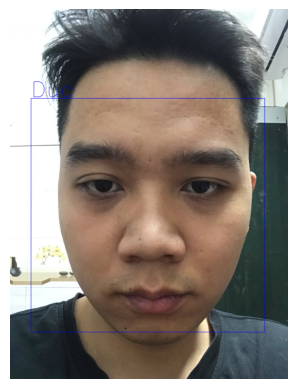

In [24]:
predict_image('/content/gdrive/MyDrive/AnhNhanDien/Duc/Duc(1).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Prediction probabilities: [[1.3671098e-02 1.5538695e-02 9.6993840e-01 8.5183111e-04]]


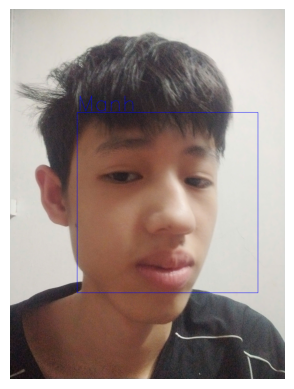

In [20]:
predict_image('/content/gdrive/MyDrive/AnhNhanDien/Manh/Manh(14).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
Prediction probabilities: [[2.6571713e-03 9.9647778e-01 1.3778834e-05 8.5124688e-04]]


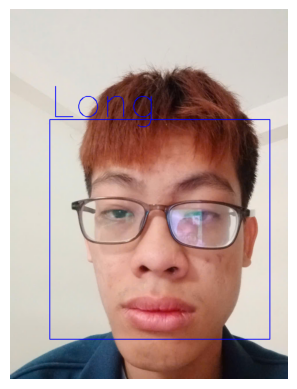

In [21]:
predict_image('/content/gdrive/MyDrive/AnhNhanDien/Long/Long(4).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
Prediction probabilities: [[0.24144526 0.00721366 0.00096411 0.75037694]]


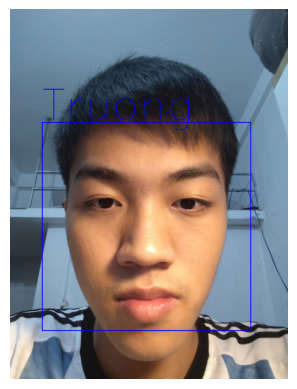

In [22]:
predict_image('/content/gdrive/MyDrive/AnhNhanDien/Truong/Truong(2).jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step


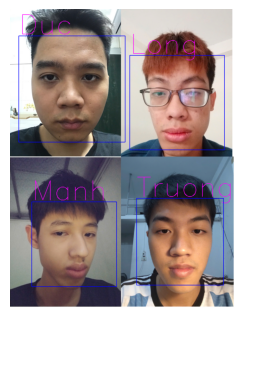

In [23]:
image = cv2.imread('/content/gdrive/MyDrive/AnhChung.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

for (x, y, w, h) in faces:
    face = image[y:y + h, x:x + w]
    face_resized = cv2.resize(face, (224, 224))
    face_resized = face_resized / 255.0

    face_resized = np.expand_dims(face_resized, axis=0)

    prediction = model.predict(face_resized)
    predicted_class = np.argmax(prediction)

    label = class_names[predicted_class]

    cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 255), 2)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()